# Train a GCN & infer node probability to be a line:

In [1]:
import torch
import numpy as np
import networkx as nx

import scipy.special as sp
import matplotlib.pyplot as plt

In [2]:
from grace.datasets import random_graph, read_coordinates
from grace.models.classifier import GCN
from grace.models.train import train_model
from grace.models.datasets import dataset_from_graph

### Generate a random graph to train the network on:

In [3]:
train_graph = random_graph()

In [4]:
pos = read_coordinates(graph=train_graph)
len(pos)

188

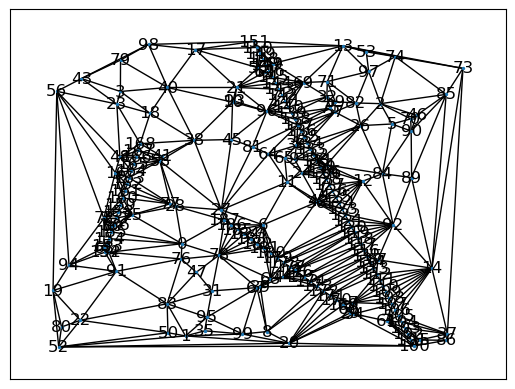

In [5]:
nx.draw_networkx(train_graph, pos=pos, node_size=2, with_labels=True)

### Create the training dataset & train the GCN model:

In [6]:
dataset = []

RNG = np.random.default_rng()

for i in range(100):
    G = random_graph(
        n_lines=RNG.integers(0, 10),
        n_chaff=RNG.integers(50, 1000),
        )
    d = dataset_from_graph(G)

    dataset += d

In [7]:
model = GCN(input_channels=3, hidden_channels=64)

train_model(model, dataset, epochs=5)

Epoch: 001, Train Acc: 0.8251, Test Acc: 0.8619
Epoch: 002, Train Acc: 0.8171, Test Acc: 0.8535
Epoch: 003, Train Acc: 0.8249, Test Acc: 0.8626
Epoch: 004, Train Acc: 0.8283, Test Acc: 0.8635


### Create an inference dataset & test performance:

In [8]:
test_graph = random_graph(n_lines=3, n_chaff=300)
test_dataset = dataset_from_graph(test_graph)

In [9]:
model.eval()

predictions = []

for data in test_dataset:  # Iterate in batches over the training/test dataset.
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    probs = sp.softmax(out.detach().numpy())
    predictions.append((int(pred.numpy()), probs))

len(predictions)

336

In [10]:
pos = read_coordinates(graph=test_graph)
len(pos)

336

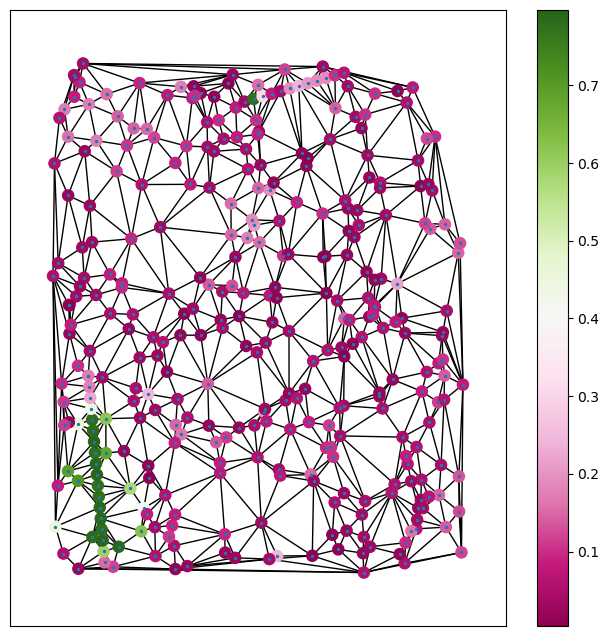

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw_networkx(test_graph, ax=ax, pos=pos, node_size=2, with_labels=False)

x = [p[0] for _, p in pos.items()]
y = [p[1] for _, p in pos.items()]

c = [pc[:, 1] for p, pc in predictions] 

scx = ax.scatter(x, y, s=64, c=c, cmap=plt.cm.PiYG)
fig.colorbar(scx)


### Save the trained model for future steps:

In [12]:
torch.save(model, "../data/gcn/model.pt")

##### Done!